In [1]:
#imports
import logging
# set seed
import pandas as pd
import numpy as np
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from sk_models import PLSRegression, StandardScaler
import matplotlib.pyplot as plt
from river_models import *

from river import stream,linear_model,preprocessing, ensemble, metrics, optim
from river.ensemble import SRPRegressor
from river.neighbors import KNNRegressor 
from sklearn.metrics import mean_squared_error
from river.utils import dict2numpy, numpy2dict

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and output directories

#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "PLN7.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =["db_id","sample_id"] #
output_cols = None
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/21.00") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\21.00\PLN7


In [3]:
data = pd.read_csv(data_file)
data=data.sample(frac=1,random_state=random_state)

pre_ind =[i for i in range(0,10000)]
pretrain_ind,pretest_ind = train_test_split(pre_ind,train_size=5/6,random_state=random_state,shuffle=False)
stream_ind = [i for i in range(10000,110000)]

pretrain_data =  ut.TabularDataset(data.iloc[pretrain_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
pretest_data = ut.TabularDataset(data.iloc[pretest_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
stream_data = ut.TabularDataset(data.iloc[stream_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)

nrow, ncol = data.shape
nrow_train = len(pretrain_data)
nrow_test = len(pretest_data)
nrow_stream = len(stream_data)

print(f"train: {nrow_train}, test: {nrow_test}, stream: {nrow_stream}")

train: 8333, test: 1667, stream: 100000


In [4]:
#setup our deep models 

def build_model(dir_,id_,scaler_):
    deep_ = torch.load(dir_/"models"/id_/"_model")
    deep_.load_state(dir_/"models"/id_/"_final")
    
    return (StreamWrapper(scaler_)|StreamDeep(deep_))


pls_model_dir = Path("D:/workspace/lazydeep/experiments/1.01/PLN7")
deep_model_dir = Path("D:/workspace/lazydeep/experiments/2.00/PLN7")

pls_scaler = PLSRegression(n_components=34).from_state(PLSRegression(n_components=34).load_state(pls_model_dir/'preprocessing'/f"_final"))      
deep_scaler = StandardScaler().from_state(StandardScaler().load_state(deep_model_dir/'preprocessing'/f"_final"))      

pls_nums = ["random_82","random_24","random_10","random_4","random_73"]
deep_nums = ["random_29","random_60","random_63","random_41","random_15"]
deep_num = 0
pls_num = 0


In [5]:
#setup evaluation
def setup_models(window_sizes=[1000,10000,20000],proportions =[1,5,10,20,50,100,200,500,1000]):
    model_dicts_ = {}
    
    for ws in window_sizes:
        for p in proportions:
            #model_dicts_[f"lwr_None_{ws}_{p}"]= StreamLocalWeightedRegression(n_neighbors= int(ws/p), window_size=ws,floor=True)
            model_dicts_[f"knn_std_{ws}_{p}_unif"]= (build_model(deep_model_dir,deep_nums[deep_num],deep_scaler) |KNNRegressor(n_neighbors= p, window_size=ws))
            model_dicts_[f"knn_std_{ws}_{p}_dist"]= (build_model(deep_model_dir,deep_nums[deep_num],deep_scaler) |KNNRegressor(n_neighbors= p, window_size=ws,aggregation_method='weighted_mean'))
            model_dicts_[f"knn_pls_{ws}_{p}_unif"]= (build_model(pls_model_dir,pls_nums[pls_num],pls_scaler)   |KNNRegressor(n_neighbors= p, window_size=ws))
            model_dicts_[f"knn_pls_{ws}_{p}_dist"]= (build_model(pls_model_dir,pls_nums[pls_num],pls_scaler)    |KNNRegressor(n_neighbors= p, window_size=ws,aggregation_method='weighted_mean'))
            #model_dicts_[f"lwr_deep_{ws}_{p}"]= (std_deep | dee | StreamLocalWeightedRegression(n_neighbors= int(ws*p), window_size=ws,floor=True)
            
    

    return model_dicts_


In [6]:
#setup our metrics and stores of results
river_models = setup_models()
full_set = river_models.keys()
metrics = {'R2':{name:metrics.R2() for name in full_set},
           'R2_rolling': {name:RollingR2(window_size=1000) for name in full_set},
           'MSE':{name:metrics.MSE() for name in river_models.keys()},
           'MSE_rolling':{name:RollingMSE(window_size=1000) for name in full_set}
          }
    


In [7]:
#so sofar we have establish our metrics and scores are correct
from tqdm.notebook import tqdm, trange

In [8]:
#take our pretrained models, now evaluate them on 

In [9]:
_,_,river_models,metrics = prequential_evaluate(pretrain_data,river_models,metrics,pretrain = len(pretrain_data),num_its= len(pretrain_data) )

  0%|          | 0/8333 [00:00<?, ?it/s]

In [10]:
preds_test,scores_test,metrics = score_evaluate(pretest_data,river_models,metrics,num_its=len(pretest_data))

  0%|          | 0/1667 [00:00<?, ?it/s]

In [11]:
preds_stream, scores_stream,river_models,metrics = prequential_evaluate(stream_data,river_models,metrics,pretrain=0,num_its=20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [12]:
def zip_dict(dict1,dict2):

    dict12 = {k:dict1[k]+dict2[k] for k in dict1.keys()}   
    return dict12

def zip_nested_dict(dict1,dict2):
    dict12 = {}
    
    for k in dict1.keys():
        dict12[k] = {name:dict1[k][name]+dict2[k][name] for name in dict1[k].keys()}
    return dict12

In [13]:
preds = zip_dict(preds_test,preds_stream)

In [14]:
scores = zip_nested_dict(scores_test,scores_stream)

In [15]:
preds_df = pd.DataFrame(preds)
preds_df.to_csv(log_dir/"preds_df.csv")


In [16]:
#findings
#1) preprocessing works, random lr things for lr don't
#) standardisation asks as regularisation

(0.4, 0.8)

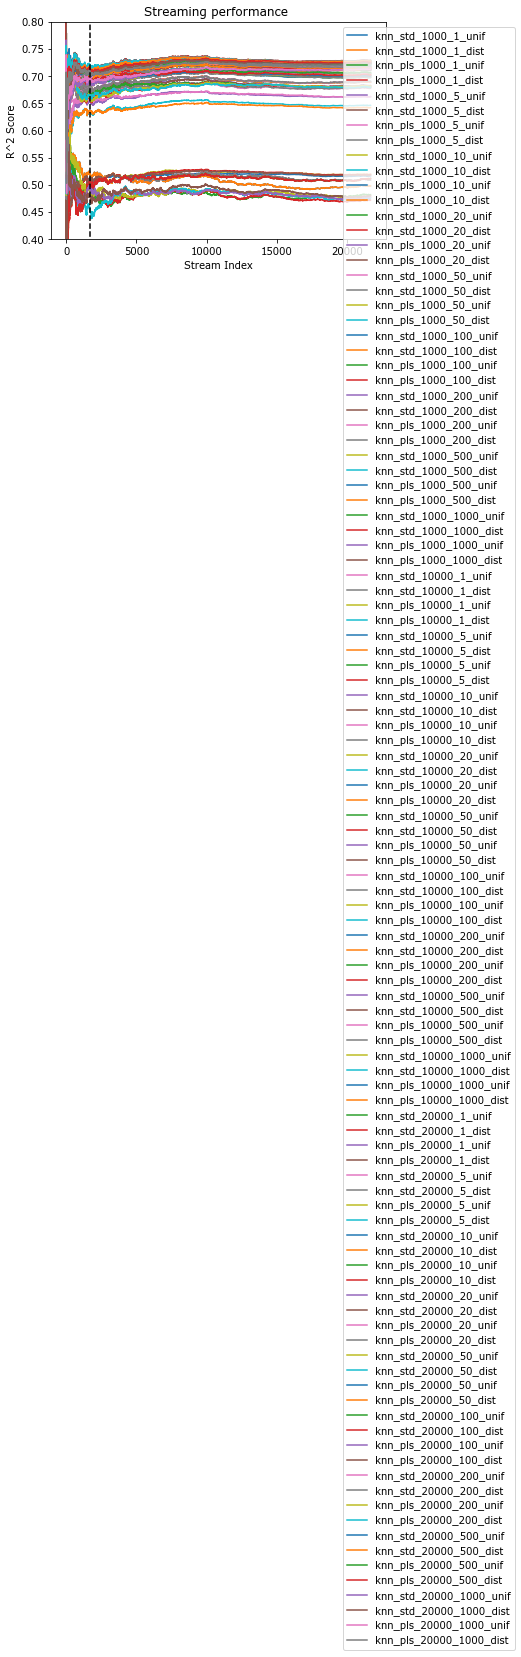

In [17]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R^2 Score")
ax.set_title("Streaming performance ")

scores_df = pd.DataFrame(scores['R2'])
scores_df.to_csv(log_dir/"r2_scores.csv")
for (columnName, columnData) in scores_df.iteritems():

    ax.plot(columnData.index,columnData,'-',label = f"{columnName}")

ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot.png",bbox_inches='tight')
ax.set_ylim(0.4,0.8)
#plt.savefig(log_dir / f"r2_plot_v2.png",bbox_inches='tight')


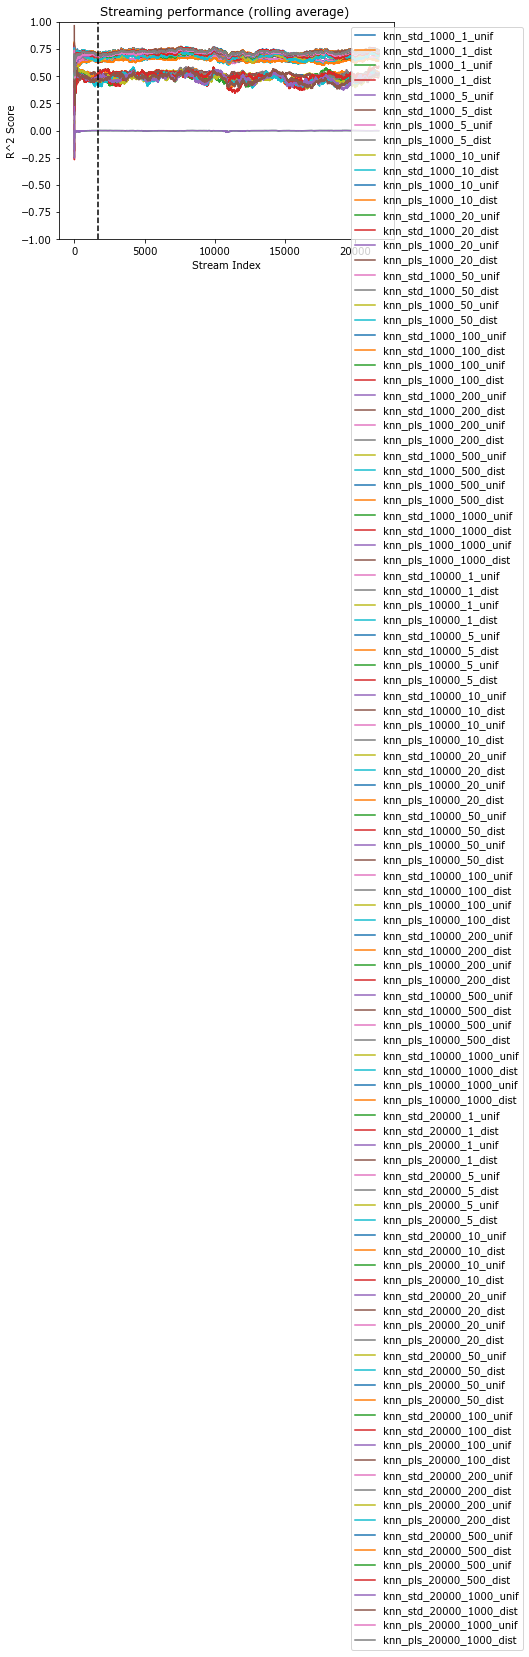

In [18]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R^2 Score")
ax.set_title("Streaming performance (rolling average) ")
    
scores_df = pd.DataFrame(scores['R2_rolling'])
scores_df.to_csv(log_dir/"r2_scores_rolling.csv")
for (columnName, columnData) in scores_df.iteritems():
    columnData
    ax.plot(columnData.index,columnData,label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_rolling.png",bbox_inches='tight')
ax.set_ylim(-1,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2.png",bbox_inches='tight')

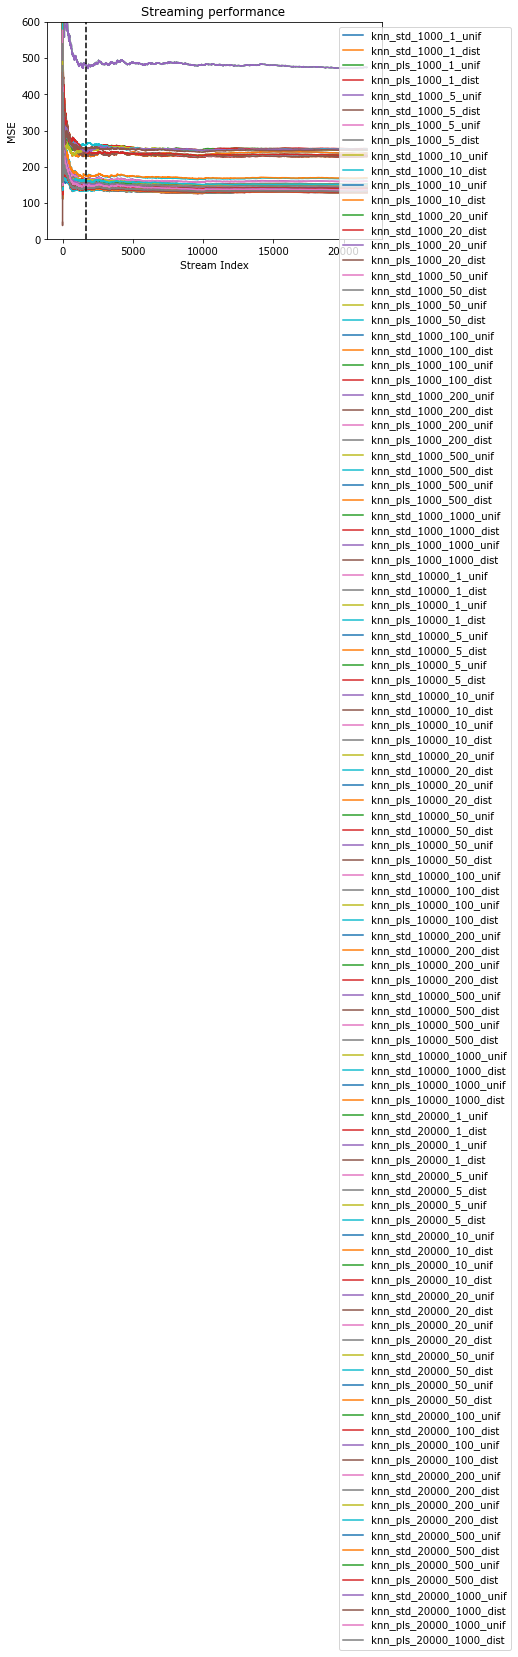

In [19]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("MSE")
ax.set_title("Streaming performance ")

scores_df = pd.DataFrame(scores['MSE'])
scores_df.to_csv(log_dir/"MSE.csv")
for (columnName, columnData) in scores_df.iteritems():
    ax.plot(columnData.index,columnData,'-',label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[0,1000],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot.png",bbox_inches='tight')
ax.set_ylim(0,600)
plt.savefig(log_dir / f"mse_plot_v2.png",bbox_inches='tight')

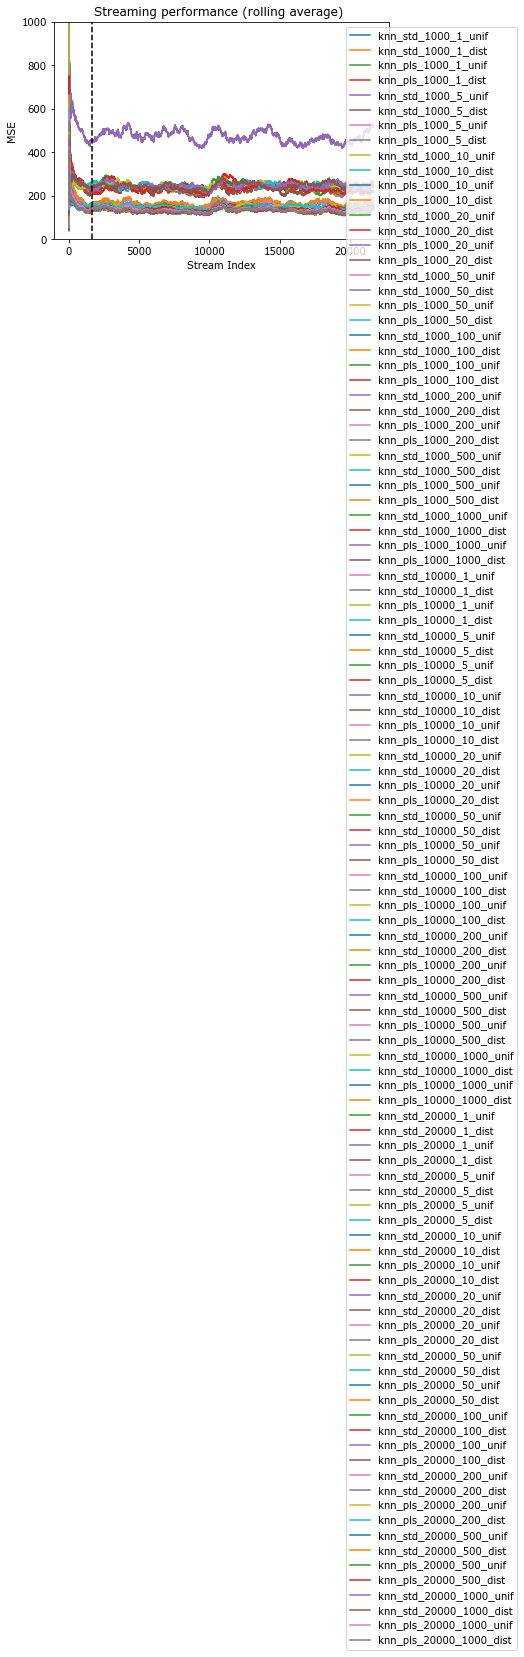

In [20]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("MSE")
ax.set_title("Streaming performance (rolling average) ")

scores_df = pd.DataFrame(scores['MSE_rolling'])
scores_df.to_csv(log_dir/"MSE_rolling.csv")
for (columnName, columnData) in scores_df.iteritems():
    ax.plot(columnData.index,columnData,label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[0,1000],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot_rolling.png",bbox_inches='tight')
ax.set_ylim(0,1000)
plt.savefig(log_dir / f"mse_plot_rolling_v2.png",bbox_inches='tight')

In [21]:
scores_df = pd.DataFrame(scores['R2_rolling'])

In [ ]:
def take_subset_by_str(dataset,string):
    col_names = dataset.columns.tolist()
    encoding = [i for i in col_names if (string in i)]
    return scores_df[encoding]
    

In [ ]:
pp_opts = ['pls_','std_']
ws_opts = ['1000_','10000_','20000_']

for pp_opt in pp_opts:
    subset1 = take_subset_by_str(scores_df,pp_opt)
    for ws_opt in ws_opts:
        subset2 = take_subset_by_str(subset1,ws_opt)
        
        fig, ax = plt.subplots()

        ax.set_xlabel("Stream Index")
        ax.set_ylabel("R2")
        ax.set_title("Streaming performance (rolling average) ")
        
        
        for (columnName, columnData) in subset2.iteritems():
            ax.plot(columnData.index,columnData,label = f"{columnName.replace(pp_opt,'',count=1).replace(ws_opt,'',count=1)}")
        ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

        ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
        plt.savefig(log_dir / f"r2_plot_{pp_opt}{ws_opt}.png",bbox_inches='tight')
        ax.set_ylim(-1,1)
        plt.savefig(log_dir / f"r2_plot_v2_{pp_opt}{ws_opt}.png",bbox_inches='tight')
    

knn_std_1000_1_unif, p = 0.7457823180661295, MSE = 237.74011311411178, R2 = 0.4981834153275436
knn_std_1000_1_dist, p = 0.7457823180661295, MSE = 237.74011311411178, R2 = 0.4981834153275436
knn_pls_1000_1_unif, p = 0.7379999323732465, MSE = 245.42736728807265, R2 = 0.4819573288478315
knn_pls_1000_1_dist, p = 0.7353920908896916, MSE = 250.04213529294734, R2 = 0.4722165783748543
knn_std_1000_5_unif, p = 0.8281741713448999, MSE = 150.25938415458754, R2 = 0.6828358076230512
knn_std_1000_5_dist, p = 0.8279248274356401, MSE = 150.54730420901407, R2 = 0.6822280723255514
knn_pls_1000_5_unif, p = 0.8253420133107785, MSE = 152.7147612585964, R2 = 0.6776530518134531
knn_pls_1000_5_dist, p = 0.8262830561069532, MSE = 152.18259509306006, R2 = 0.67877633641263
knn_std_1000_10_unif, p = 0.8398862616014866, MSE = 139.83543866607323, R2 = 0.704838441740363
knn_std_1000_10_dist, p = 0.8399304853881695, MSE = 139.90367135197914, R2 = 0.7046944176926083
knn_pls_1000_10_unif, p = 0.8382433605540266, MSE = 

(0.0, 500.0)

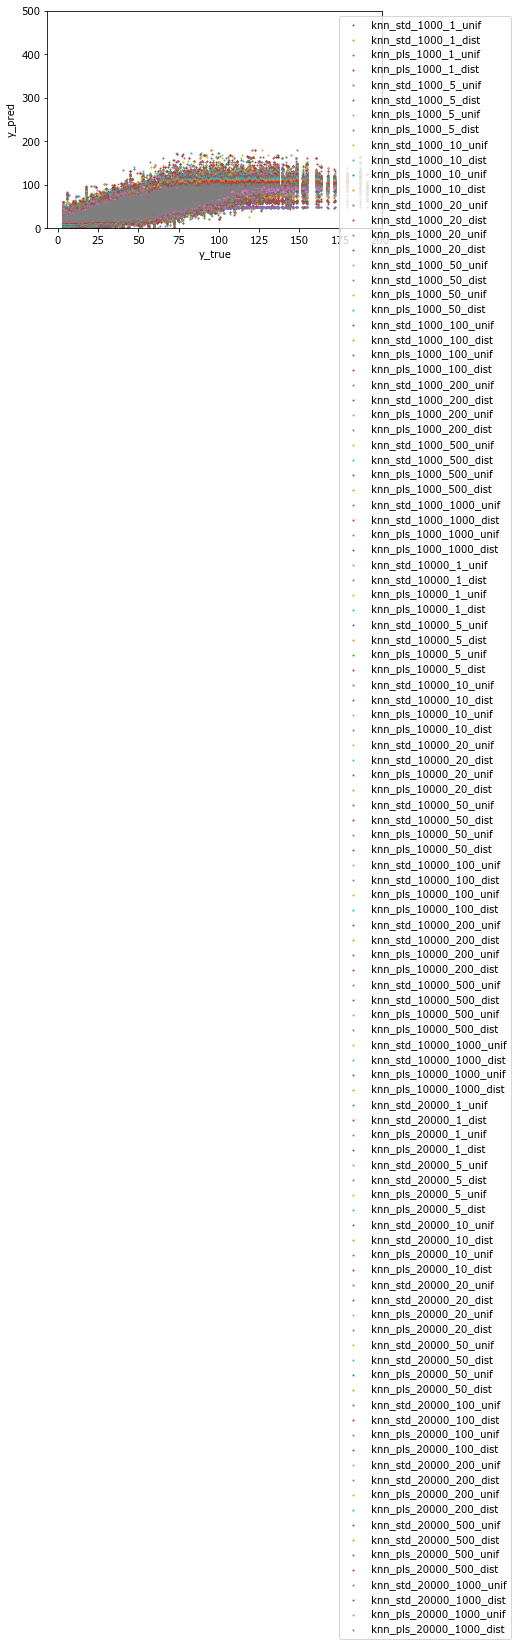

In [25]:
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

fig, ax = plt.subplots()
ax.set_ylabel('y_pred')
ax.set_xlabel('y_true')

for (columnName, columnData) in preds_df.iteritems():
        if not columnName == 'y':
            ax.scatter(preds_df['y'],columnData,label = f"{columnName}",s=1)
            
            corr_coef = scipy.stats.pearsonr(columnData, preds_df['y'])
            r2 = r2_score(preds_df['y'],columnData)
            #slope, intercept, r, p, stderr = scipy.stats.linregress(columnData, preds_df['y'])
            loss = mean_squared_error(preds_df['y'], columnData)
            mae = mean_absolute_error(preds_df['y'], columnData)    
            print(f"{columnName}, p = {corr_coef[0]}, MSE = {loss}, R2 = {r2}")
            
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylim(0,500)

In [ ]:
ghjg